In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from pprint import pprint
import shutil

In [2]:
from torchvision.utils import draw_segmentation_masks
import cv2
from torchvision.transforms import functional as F
import torch
import torchvision
from torchvision.io import read_image
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
import pandas as pd
import MyUtils.Dataset
from MyUtils.visualize import visualize_masks
import albumentations as A
from torch.utils.data import DataLoader
from MyUtils import transforms, utils, engine, train as transforms, utils, engine, train
from MyUtils.utils import collate_fn
from MyUtils.engine import train_one_epoch, evaluate
from MyUtils.plot_statistic import plot_stats

from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, maskrcnn_resnet50_fpn, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from tqdm import tqdm

import random

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

from IPython.display import display, update_display, clear_output

C:\Users\User\Petr\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Dataset classes is ['Asphalt road', 'Country road', 'Water']
Class index is {'Asphalt road': 1, 'Country road': 2, 'Water': 3}
Class index inverted is {1: 'Asphalt road', 2: 'Country road', 3: 'Water'}


<Axes: xlabel='Classes', ylabel='Counts'>

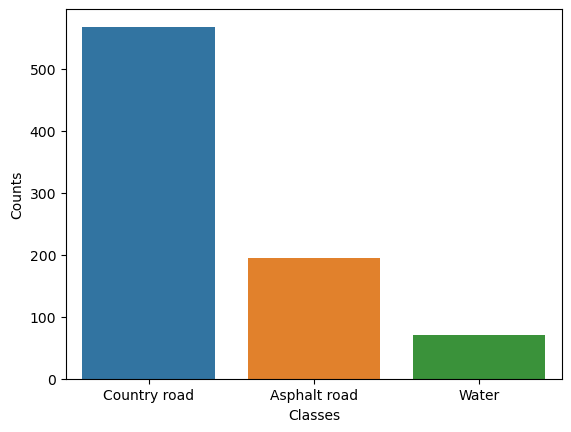

In [3]:
random.seed(42)
torch.manual_seed(42)

path = 'C:/Users/User/Petr/Net_4/Dataset_4/'
visualise_path = 'C:/Users/User/Petr/Net_4/Visualize/'

obj_colors = {
    'Country road': (255, 136, 0),
    'Asphalt road': (0, 0, 0),
    'Water': (0, 0, 255),
    'Road': (255, 136, 0)
}

classes = list(set([mask.split('-')[-2] for mask in os.listdir(path + 'masks/') if mask.endswith('.npy')]))

classes.sort()

class_index = {cls: index + 1 for index, cls in enumerate(classes)}

inv_classes = {v: k for k, v in class_index.items()}


weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
weights_v2 = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT

print(f'Dataset classes is {classes}')
print(f'Class index is {class_index}')
print(f'Class index inverted is {inv_classes}')

dataset_stats = defaultdict(int)

for mask in os.listdir(path + 'masks/'):
    if mask.endswith('.npy'):
        dataset_stats[mask.split('-')[-2]] += 1

df = pd.DataFrame(data=dataset_stats.items(), columns=['Classes', 'Counts'])

sns.barplot(data=df, x='Classes', y='Counts')

In [4]:
old_path = 'C:/Users/User/Petr/Net_4/Dataset/'

FDA_source = {
    'reference_images': [old_path + 'images/mmih-3-3.jpg', old_path + 'images/B.protopop-2-2.jpg', old_path + 'images/malin-2-2.jpg', old_path + 'images/TEO_1_00515.JPG'],
    'read_fn': lambda x: cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB),
    'p': 0.3
}

transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    #A.RandomBrightnessContrast(p=0.5),
    #A.RandomSizedBBoxSafeCrop(height=1000, width=1000, erosion_rate=0.0, interpolation=1, always_apply=False, p=0.3),
    #A.ToSepia(always_apply=False, p=0.5),
    A.OneOf([
        A.RGBShift(r_shift_limit=(-10, 10), g_shift_limit=(-10, 10), b_shift_limit=(-10, 10), always_apply=False, p=0.1),
        A.GaussNoise(p=0.1)
    ], p=1.0),
    #A.RandomGravel(gravel_roi=(0.1, 0.1, 0.9, 0.9), number_of_patches=2, always_apply=False, p=0.5),
    #A.RandomShadow(shadow_roi=(0, 0, 1, 1), always_apply=False, p=0.3),
    #A.Solarize(threshold=(200, 200), always_apply=False, p=0.5),
    #A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5, always_apply=False, p=0.3),
    #A.CropNonEmptyMaskIfExists(height=3000, width=3000, ignore_values=None, ignore_channels=None, always_apply=False, p=0.5),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [5]:
dataset_train_initial = MyUtils.Dataset.RoadsDataset(root=path, class_index=class_index, transform=transform)
dataset_test_initial = MyUtils.Dataset.RoadsDataset(root=path, class_index=class_index, transform=None)

print(len(dataset_train_initial))

460


In [ ]:
image, target = dataset_train_initial[38]

In [ ]:
visualize_masks(image, target, inv_classes, obj_colors=obj_colors, show=True, alpha=0.7)
#visualize_masks(image, show=True)

In [6]:
def my_loss(mask_logits, proposals, gt_masks, gt_labels, mask_matched_idxs):
    # type: (Tensor, List[Tensor], List[Tensor], List[Tensor], List[Tensor]) -> Tensor
    """
    Args:
        proposals (list[BoxList])
        mask_logits (Tensor)
        targets (list[BoxList])

    Return:
        mask_loss (Tensor): scalar tensor containing the loss
    """

    #print('New loss is working')

    discretization_size = mask_logits.shape[-1]
    labels = [gt_label[idxs] for gt_label, idxs in zip(gt_labels, mask_matched_idxs)]
    mask_targets = [
        torchvision.models.detection.roi_heads.project_masks_on_boxes(m, p, i, discretization_size) for m, p, i in zip(gt_masks, proposals, mask_matched_idxs)
    ]

    labels = torch.cat(labels, dim=0)
    mask_targets = torch.cat(mask_targets, dim=0)
    classes = mask_targets.shape[-1]
    pos_weight = torch.full((classes,), 3).to(labels.device)
    #print(mask_targets.shape)

    # torch.mean (in binary_cross_entropy_with_logits) doesn't
    # accept empty tensors, so handle it separately
    if mask_targets.numel() == 0:
        return mask_logits.sum() * 0

    #print(mask_logits[torch.arange(labels.shape[0], device=labels.device), labels])
    #print(mask_targets)

    mask_loss = torch.nn.functional.binary_cross_entropy_with_logits(input=mask_logits[torch.arange(labels.shape[0], device=labels.device), labels], target=mask_targets, pos_weight=pos_weight) #pos_weight=pos_weight
    return mask_loss

#torchvision.models.detection.roi_heads.mask_rcnn_loss = my_loss

In [7]:
def get_mask_model(weights_path=None):
    model = maskrcnn_resnet50_fpn(weights=weights)
    # Get the number of input features for the classifier
    in_features_box = model.roi_heads.box_predictor.cls_score.in_features
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
    dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(classes))

# Replace the mask predictor
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(classes))

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)   

# Set the model's device and data type
    #model.to(device=device)

# Add attributes to store the device and model name for later reference
    #model.device = device
    model.name = 'maskrcnn_resnet50_fpn_v2'
    return model

def get_mask_model_v2(weights_path=None):
    model = maskrcnn_resnet50_fpn_v2(weights=weights_v2)
    torchvision.models.detection.roi_heads.maskrcnn_loss = my_loss
    # Get the number of input features for the classifier
    in_features_box = model.roi_heads.box_predictor.cls_score.in_features
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
    dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(classes) + 1)

# Replace the mask predictor
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(classes) + 1)

    #model.roi_heads.maskrcnn_loss = my_loss

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)   

# Set the model's device and data type
    #model.to(device=device)

# Add attributes to store the device and model name for later reference
    #model.device = device
    model.name = 'maskrcnn_resnet50_fpn_v2'
    return model

In [ ]:
save_path = 'C:/Users/User/Petr/Net_4/save_model'
log_path = 'C:/Users/User/Petr/Net_4/Metric_log'

indices = torch.randperm(len(dataset_train_initial)).tolist()
thirty_pc = int(len(dataset_train_initial) * 0.15)
dataset_train = torch.utils.data.Subset(dataset_train_initial, indices[:-thirty_pc])
dataset_test = torch.utils.data.Subset(dataset_test_initial, indices[-thirty_pc:])

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #torch.device('cuda') if torch.cuda.is_available() else 

model = get_mask_model_v2() #weights_path=f'{save_path}/weights_20_loss.pth'

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
    #params1 = [p for p in model.roi_heads.keypoint_head.parameters() if p.requires_grad]
    
optimizer = torch.optim.SGD(params, lr=1.0e-4, momentum=0.90, weight_decay=0.0001)#, weight_decay=0.0001
    
    #optimizer = torch.optim.SGD([{'params': params1},
    #                             {'params': model.roi_heads.keypoint_predictor.parameters(), 'lr': .001},], lr=0.001, momentum=0.90)#, weight_decay=0.0001
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
num_epochs = 50

bbox_stats = []
masks_stats=[]

loss_bb = []
loss_masks = []
loss = []

start_from = 0

for epoch in range(0, num_epochs):
    logger = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=int(len(dataset_train) / 10))
    lr_scheduler.step()
    evaluator = evaluate(model, data_loader_test, device)

    bbox_stats.append(evaluator.coco_eval['bbox'].stats[:6])
    masks_stats.append(evaluator.coco_eval['segm'].stats[:6])

    loss_masks.append(logger.meters['loss_mask'].global_avg)
    loss_bb.append(logger.meters['loss_box_reg'].global_avg)
    loss.append(logger.meters['loss'].global_avg)
        
    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), f'{save_path}/test_{start_from + epoch+1}_loss.pth')
        plot_stats(epoch + 1, bbox_stats, loss_bb, loss, masks_stats=masks_stats, loss_masks=loss_masks, num=epoch+1, log_path=log_path)#, num=num
            
plot_stats(num_epochs, bbox_stats, loss_bb, loss, masks_stats=masks_stats, loss_masks=loss_masks, num=epoch+1, show=True, log_path=log_path)

In [ ]:
torch.save(model.state_dict(), f'{save_path}/weights_10_loss.pth')

In [11]:
test_path = 'C:/Users/User/Petr/Net_4/test_model/images/'
out_path = 'C:/Users/User/Petr/Net_4/test_model/pred/'

save_path = 'C:/Users/User/Petr/Net_4/save_model/'
model = get_mask_model_v2(save_path + 'weights_40_loss.pth')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
threshold = 0.975
mask_threshold = 0.6

i = 0
for image in tqdm(os.listdir(test_path)):
    img = cv2.imdecode(np.fromfile(os.path.join(test_path, image), dtype=np.uint8), cv2.IMREAD_UNCHANGED) #cv2.imread(os.path.join(test_path, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_orig = cv2.imdecode(np.fromfile(os.path.join(test_path, image), dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    img = F.to_tensor(img)
    type(img)
    img = img.to(device)
    with torch.no_grad():
        #model_test.to(device)
        model.eval()
        out = model([img,])
        out = out[0]
    #img = (img[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)

    scores_valid = out['scores'] > threshold
    labels_valid = out['labels'] < 3

    target = {}
    target['masks'] = out['masks'][scores_valid * labels_valid]
    target['boxes'] = out['boxes'][scores_valid * labels_valid]
    #print(target['boxes'])
    #print(target['masks'])
    target['labels'] = out['labels'][scores_valid * labels_valid]
    
    #target['masks'] = out['masks'][labels_valid]
    #print_contours(target, image)
    #target['boxes'] = out['boxes'][labels_valid]
    #target['labels'] = out['labels'][labels_valid]

    img =  F.to_tensor(print_contours(target, img_orig))

    visualize_masks(img.detach().cpu(), target=target, inv_classes=inv_classes, obj_colors=obj_colors, alpha=0.5, save_path=out_path + image, mask_threshold=mask_threshold) # .detach().cpu()

100%|██████████| 703/703 [19:40<00:00,  1.68s/it]


In [ ]:
cv2.__version__

In [10]:
def print_contours(target, img):
    if not len(target['masks']):
        return img

    label_masks_threshold = {1: 0.55, 2: 0.61, 3: 0.1}
    masks = target['masks'] #> mask_threshold
    boxes = target['boxes']
    
    masks = masks.squeeze(1)
    #masks = masks.detach().cpu().numpy()
    labels = set(target['labels'].detach().cpu().numpy())

    for label in labels:
        label_masks = target['labels'] == label

        #print(label_masks)

        label_boxes = boxes[label_masks]

        label_boxes = label_boxes.detach().cpu().numpy()

        label_masks = masks[label_masks] > label_masks_threshold[label]

        label_masks = label_masks.detach().cpu().numpy()

        total_mask = label_masks[0]

        for i in range(1, label_masks.shape[0]):
            total_mask = total_mask | label_masks[i]
        
        total_mask = total_mask.astype('uint8')
        contours, heir = cv2.findContours(total_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        areas = [cv2.contourArea(c) for c in contours]
        try:
            max_area = max(areas)
        except ValueError:
            print('areas is empty. skip.')
        valid_contours = tuple([c for c in contours if cv2.contourArea(c) > max_area*0.5])
        eps = 20
        for contour in valid_contours:
            c = np.squeeze(contour)
            step = int(len(c) * 0.15)
            for point in c[::step]:
                skip_point = False
                x, y = point
                for box in label_boxes:
                    x_min, y_min, x_max, y_max = box
                    if (abs(x - x_min) <= eps or abs(x - x_max) <= eps) or (abs(y - y_min) <= eps or abs(y - y_max) <= eps):
                        skip_point = True
                        break
                if skip_point:
                    continue
                img = cv2.circle(img.copy(), tuple(point), 5, (0,0,255), -1)
        #print(len(valid_contours))
        #img = cv2.drawContours(img.copy(), valid_contours, -1, (255,0,0), 10)

    return img
    #print(contours)
        #cv2.imwrite(out_path + f'{image}_contouered_mask_{num + 1}.jpg', cv2.drawContours(cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2RGB), contours, -1, (255,0,0), 10))

#plt.imsave(out_path + 'image.jpg', mask, cmap='gray')

In [ ]:
False | False

In [ ]:
#contours[0].squeeze(1).shape
cv2.imwrite(out_path + f'contouered_mask.jpg', cv2.drawContours(mask * 256, contours, -1, (255,0,0), 10))

In [ ]:
test_path = 'C:/Users/User/Petr/Net_4/test_model/images/'

for image in os.listdir(test_path):
    image_original = cv2.imread(test_path + image)
    image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)

    image_1 = image_original[2500:, 2500:]
    cv2.imwrite(test_path + f'{image[:-4]}_1.jpg', cv2.cvtColor(image_1, cv2.COLOR_RGB2BGR))

    image_2 = image_original[2500:, : 2500]
    cv2.imwrite(test_path + f'{image[:-4]}_2.jpg', cv2.cvtColor(image_2, cv2.COLOR_RGB2BGR))
    
    image_3 = image_original[:2500, 2500:]
    cv2.imwrite(test_path + f'{image[:-4]}_3.jpg', cv2.cvtColor(image_3, cv2.COLOR_RGB2BGR))
    
    image_4 = image_original[:2500, :2500]
    cv2.imwrite(test_path + f'{image[:-4]}_4.jpg', cv2.cvtColor(image_4, cv2.COLOR_RGB2BGR))

In [ ]:
model = get_mask_model()
model.eval()
pred = model([image.to(device)])
output = pred[0]

visualize_masks(image.detach().cpu(), output, inv_classes, obj_colors=obj_colors, show=True)

In [ ]:
model_v2 = get_mask_model_v2()
model_v2.eval()
pred_v2 = model_v2([image.to(device)])
output_v2 = pred_v2[0]

visualize_masks(image.detach().cpu(), output_v2, inv_classes, obj_colors=obj_colors, show=True)

In [ ]:
mask_path = 'C:/Users/User/Petr/Net_4/Dataset/masks/'
files = os.listdir(mask_path)
for mask in files:
    if 'Asphalt road' in mask:
        try:
            new_name = mask.replace('Asphalt road', 'Road')
            os.rename(mask_path + mask, mask_path + new_name)
        except FileExistsError:
            #new_name = mask.replace('Asphalt road', 'Road')
            number = int(new_name.split('-')[-1][:-4])
            new_name = '-'.join(new_name.split('-')[:-1]) + '-' + str(number + 1) + '.npy'
            while new_name in os.listdir(mask_path):
                number += 1
                new_name = '-'.join(new_name.split('-')[:-1]) + '-' + str(number + 1) + '.npy'
            os.rename(mask_path + mask, mask_path + new_name)
    if 'Country road' in mask:
        try:
            new_name = mask.replace('Country road', 'Road')
            os.rename(mask_path + mask, mask_path + new_name)
        except FileExistsError:
            #new_name = mask.replace('Country road', 'Road')
            number = int(new_name.split('-')[-1][:-4])
            new_name = '-'.join(new_name.split('-')[:-1]) + '-' + str(number + 1) + '.npy'
            while new_name in os.listdir(mask_path):
                number += 1
                new_name = '-'.join(new_name.split('-')[:-1]) + '-' + str(number + 1) + '.npy'
            os.rename(mask_path + mask, mask_path + new_name)
    if 'Water' in mask:
        os.remove(mask_path + mask)

In [ ]:
for mask in os.listdir(mask_path):
    if 'Country road' in mask:
        os.remove(mask_path + mask)

In [ ]:
'task-3848-annotation-2700-by-1-tag-Country road-0.npy'.replace('Country road', 'Road')

In [ ]:
file = 'task-3850-annotation-2702-by-1-tag-Asphalt road-10.npy'

number = int(file.split('-')[-1][:-4])

print(number)

new_file = '-'.join(file.split('-')[:-1]) + '-' + str(number + 1) + '.npy'

print(new_file)

In [ ]:
'-'.join(file.split('-')[:-1])

In [ ]:
ann = pd.read_json('C:/Users/User/Petr/Net_4/Dataset/annotations.json', orient='records')

In [ ]:
ann.head()

In [ ]:
ann[ann['tag'][0][0]['brushlabels'] != ['Water']].index

In [ ]:
labels = [label for data in ann['tag'][0] for label in data['brushlabels']]
print(labels)

In [ ]:
indxs = []
for row in ann.iterrows():
    labels = []
    for data in row[1].tag:
        labels.extend(data['brushlabels'])
    if 'Water' not in labels:
        indxs.append(row[0])

print(indxs)

In [ ]:
ann_1 = ann.iloc[indxs]

In [ ]:
ann_1.reset_index(drop=True, inplace=True)

In [ ]:
ann_1.iloc[90]

In [ ]:
paths = ['task-3848-annotation-2700-by-1-tag-Asphalt road-0.npy', 'task-3848-annotation-2700-by-1-tag-Country road-0.npy']

masks = [np.load(path + 'masks/' + mask_path)[2500:, :2500] for mask_path in paths]

#cut_mask = mask[2500:, 2500:]

masks = torch.as_tensor(np.array(masks), dtype=torch.bool)

print(type(masks))

In [ ]:
image = cv2.imread(path + 'images/mmih-0-0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[2500:, :2500]
cv2.imwrite(path + 'crop.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
image = F.to_tensor(image)
image = (image * 255).to(dtype=torch.uint8)

In [ ]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

masked_image = draw_segmentation_masks(image=image, masks=masks)
print(type(masked_image))
masked_image = F.to_pil_image(masked_image)



In [ ]:
plt.figure(figsize=(20,15))
plt.imshow(np.asarray(masked_image))

In [ ]:
annotations = pd.read_json(path + 'annotations.json', orient='records')
annotations.head()

In [ ]:
mask_paths = annotations['masks']

areas = []

for paths in tqdm(mask_paths):
    masks = np.array([np.load(path) for path in paths])
    bbox = masks_to_boxes(torch.tensor(masks, dtype=torch.uint8)).detach().cpu().numpy()
    areas.extend(((bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])))

print(areas)

In [ ]:
ratios = [area / 6250000 for area in areas]

In [ ]:
import seaborn
sns.boxplot(ratios)

In [ ]:
mask = np.load("C:/Users/User/Petr/Net_4/Dataset/masks/task-3976-annotation-2832-by-1-tag-Asphalt road-0.npy")

print(type(mask), mask.shape)

mask_1 = torch.from_numpy(mask)

print(mask_1, type(mask_1), mask_1.shape)

In [ ]:
mask = np.load(mask_paths[0])

bbox = masks_to_boxes(torch.tensor([mask], dtype=torch.uint8)).detach().cpu().numpy()
area = ((bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0]))[0]
print(area, 2500*2500, area / (2500*2500))

In [ ]:
data = []
new_path = 'C:/Users/User/Petr/Net_4/Dataset_4_single/'

rows = annotations.iterrows()

total_area = 6250000

print("Start converting")

for num, row in enumerate(rows):
    task_1, task_2, task_3, task_4 = {}, {}, {}, {}
    id = row[1]['id']
    image_path = path + 'images/' + '-'.join(row[1]['image'].split('-')[1:])
    image_name = '-'.join(row[1]['image'].split('-')[1:])[:-4]
    image_original = cv2.imread(image_path)
    image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
    masks = [(np.load(path + 'masks/' + mask), mask) for mask in os.listdir(path + 'masks/') if f'task-{id}' in mask]

    image = image_original[2500:, 2500:]
    cv2.imwrite(new_path + f'images/{image_name}_1.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    task_1['image_path'] = new_path + f'images/{image_name}_1.jpg'

    image = image_original[2500:, :2500]
    cv2.imwrite(new_path + f'images/{image_name}_2.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    task_2['image_path'] = new_path + f'images/{image_name}_2.jpg'
    
    image = image_original[:2500, 2500:]
    cv2.imwrite(new_path + f'images/{image_name}_3.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    task_3['image_path'] = new_path + f'images/{image_name}_3.jpg'
    
    image = image_original[:2500, :2500]
    cv2.imwrite(new_path + f'images/{image_name}_4.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    task_4['image_path'] = new_path + f'images/{image_name}_4.jpg'
    
    #masks = [np.where(mask[:,...] > 0, 1) for mask in masks]

    task_1['masks'] = []
    task_2['masks'] = []
    task_3['masks'] = []
    task_4['masks'] = []

    task_1['id'] = id
    task_2['id'] = id
    task_3['id'] = id
    task_4['id'] = id

    for num_m, mask in enumerate(masks):
        mask_type = '-'.join(mask[1].split('-')[-2:])[:-4]
        if 'Water' in mask_type:
            continue
        if mask[0].shape[0] != 5000 or mask[0].shape[1] != 5000:
            continue
        print(mask_type)

        mask_np = mask[0][2500:, 2500:]
        if np.any(mask_np):
            bbox = masks_to_boxes(torch.tensor(mask_np.reshape(1, 2500, 2500), dtype=torch.uint8)).detach().cpu().numpy()
            area = ((bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0]))[0]
            if area / total_area > 0.01:
                np.save(new_path + f'masks/{image_name}_1-Road-{num_m}.npy', mask_np)
                task_1['masks'].append(new_path + f'masks/{image_name}_1-Road-{num_m}.npy')

        mask_np = mask[0][2500:, :2500]
        if np.any(mask_np):
            bbox = masks_to_boxes(torch.tensor(mask_np.reshape(1, 2500, 2500), dtype=torch.uint8)).detach().cpu().numpy()
            area = ((bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0]))[0]
            if area / total_area > 0.01:
                np.save(new_path + f'masks/{image_name}_2-Road-{num_m}.npy', mask_np)
                task_2['masks'].append(new_path + f'masks/{image_name}_2-Road-{num_m}.npy')
        
        mask_np = mask[0][:2500, 2500:]
        if np.any(mask_np):
            bbox = masks_to_boxes(torch.tensor(mask_np.reshape(1, 2500, 2500), dtype=torch.uint8)).detach().cpu().numpy()
            area = ((bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0]))[0]
            if area / total_area > 0.01:
                np.save(new_path + f'masks/{image_name}_3-Road-{num_m}.npy', mask_np)
                task_3['masks'].append(new_path + f'masks/{image_name}_3-Road-{num_m}.npy')
        
        mask_np = mask[0][:2500, :2500]
        if np.any(mask_np):
            bbox = masks_to_boxes(torch.tensor(mask_np.reshape(1, 2500, 2500), dtype=torch.uint8)).detach().cpu().numpy()
            area = ((bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0]))[0]
            if area / total_area > 0.01:
                np.save(new_path + f'masks/{image_name}_4-Road-{num_m}.npy', mask_np)
                task_4['masks'].append(new_path + f'masks/{image_name}_4-Road-{num_m}.npy')

    if len(task_1['masks']) > 0:
        data.append(task_1)
    if len(task_2['masks']) > 0:
        data.append(task_2)
    if len(task_3['masks']) > 0:
        data.append(task_3)
    if len(task_4['masks']) > 0:
        data.append(task_4)

    clear_output(wait=True)
    print(f'{num}/{len(annotations)} compleate...')


df_ann = pd.DataFrame(data=data)
df_ann.head()

In [ ]:
annotations.iloc[86]

In [ ]:
df_ann.to_json(new_path + 'annotations.json', orient='records')

In [ ]:
df_ann.loc[df_ann['id'] == 3975]

In [ ]:
ann = annotations.drop(annotations['masks'] != [])